In [0]:

%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf 6864-hw2

In [0]:
import os
import sys
os.makedirs('6864-hw2', exist_ok=True)
sys.path.append("/content/6864-hw2")

import numpy as np
import torch
import torch.nn as nn

In [0]:
import requests

file_names = ['train.dat', 'train.tag', 'test.dat', 'test.tag']
for file_name in file_names:
    r = requests.get('http://people.csail.mit.edu/andyyuan/docs/' + file_name,
                     allow_redirects=True)
    open('/content/6864-hw2/' + file_name, 'wb').write(r.content)

device = "cuda" if torch.cuda.is_available() else "cpu"

# **Introduction**

In this lab, you will explore two types of recurrent architectures to perform sequential classification. Specifically, you are asked to implement and train a vanilla RNN (no gate mechanism) and an LSTM for the task of Name Entity Recognition (NER). To complete this lab, you need to first understand the recurrent update equations introduced in lecture, and transform them into PyTorch code.

In NER, your task is to predict the correct name entity of each word in a sentence.
We are going to work with a dataset called MIT-Restaurants. We've helped you preprocessed the data. They now look like this:

In [4]:
def read_file(f_name):
    data = []
    with open(f_name, 'r') as f:
        for line in f:
            data.append(line.strip().split())
    return data

train_data = read_file('/content/6864-hw2/train.dat')
train_tags = read_file('/content/6864-hw2/train.tag')

test_data = read_file('/content/6864-hw2/test.dat')
test_tags = read_file('/content/6864-hw2/test.tag')

print('Total amount of training samples: %d' % len(train_data))
print('Total amount of testing samples: %d' % len(test_data))
print('Average sentence length in training data: %f' % (
    np.mean([len(sent) for sent in train_data])))

print('\nExample:')
print('The first sentence is: ' + str(train_data[0]))
print('Its corresponding name entity sequence is: ' + str(train_tags[0]))

Total amount of training samples: 7660
Total amount of testing samples: 1521
Average sentence length in training data: 9.206919

Example:
The first sentence is: ['2', 'start', 'restaurants', 'with', 'inside', 'dining']
Its corresponding name entity sequence is: ['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity']


Here are some helper functions and more data preprocessing before we move on to implementing our models. No code to write in this section but please do understand it as some variables defined here will be used later for training and evaluation. 

In [5]:
# From train data, collect all unique word types as a set and add 'UNK' to it.
# Unseen words in test data will be turned into 'UNK'.
vocab_set = list(set([word for sent in train_data for word in sent])) + ['UNK']
num_vocabs = len(vocab_set)
print("Number of word types, including 'UNK': %d" % num_vocabs)

# Assign each word type an unique id.
vocab2id = {v : i for i, v in enumerate(vocab_set)}


# We also collect all tag (class) types and assign an unique id to each of them.
# There won't be unseen tag type in test data.
tag_set = list(set([tag for tag_seq in train_tags for tag in tag_seq]))
num_tags = len(tag_set)
print("Number of tag types: %d" % num_tags)
print('These are the tag types: ' + str(tag_set))

tag2id = {t : i for i, t in enumerate(tag_set)}
# Inverse dictionary of tag2id, you will need this during evaluation!
id2tag = {i : t for t, i in tag2id.items()}

Number of word types, including 'UNK': 3805
Number of tag types: 17
These are the tag types: ['B-Amenity', 'I-Restaurant_Name', 'B-Price', 'I-Amenity', 'B-Rating', 'I-Price', 'I-Rating', 'I-Cuisine', 'B-Cuisine', 'O', 'B-Location', 'B-Dish', 'B-Hours', 'B-Restaurant_Name', 'I-Location', 'I-Hours', 'I-Dish']


Now that you have understood what raw data look like, it's your turn to transform them into the format that our model actually takes as input: one-hot encoding.

In [6]:
def one_hot_encoding(sent, vocab2id):
    # Example input `sent`: ['2', 'start', 'restaurants', 'with', 'inside', 'dining']
    one_hot = torch.zeros(len(sent), len(vocab2id))
    ### Your code here! ###
    for i, word in enumerate(sent):
        try:
            j = vocab2id[word]
        except:
            j = vocab2id['UNK']
        one_hot[i, j] = 1
    ###
    return one_hot


def tag_to_id(tag_seq, tag2id):
    id_seq = None ### Your code here! ###
    id_seq = torch.LongTensor([tag2id[tag] for tag in tag_seq])
    return id_seq


# Apply one-hot encoding to data.
train_data_oh_list = [one_hot_encoding(sent, vocab2id) for sent in train_data]
# Transform tag names into ids.
train_tags_id_list = [tag_to_id(tag_seq, tag2id) for tag_seq in train_tags]

# train_data_oh_list should now be a list of 2d-tensors, each has shape (sent_len, num_vocabs)
# Note that to utilize the `shape` attribute, each element in the list should
# already be a torch tensor.
print("First sentence has shape: %s" % str(train_data_oh_list[0].shape))
print("Fifth sentence has shape: %s" % str(train_data_oh_list[4].shape))
# train_tags_id_list is a list of 1d-tensors, each that has shape (sent_len,)
print("first tag sequence has shape: %s" % train_tags_id_list[0].shape)
print("Fifth tag sequence has shape: %s" % train_tags_id_list[4].shape)


# Apply same conversion to test dataset.
test_data_oh_list = [one_hot_encoding(sent, vocab2id) for sent in test_data]
test_tags_id_list = [tag_to_id(tag_seq, tag2id) for tag_seq in test_tags]

First sentence has shape: torch.Size([6, 3805])
Fifth sentence has shape: torch.Size([12, 3805])
first tag sequence has shape: 6
Fifth tag sequence has shape: 12


# **Part 1: Recurrent Neural Network (RNN)**

In this part, you will implement a vanilla RNN. You are not allowed to use the PyTorch built-in RNN/RNNCell modules--you will have to implement the update rules yourself.

In [0]:
class RNN(nn.Module):
    # A torch module implementing an RNN. The `forward` function should just
    # perform one step of update and output logits before softmax.

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        # `input_size`, `hidden_size`, and `output_size` are all int.

        ### Your code here! ###
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        ###

    def forward(self, input, hidden):
        # `input` is a 2d-tensor of shape (1, input_size); `hidden` is another
        # 2d-tensor of shape (1, hidden_size), representing the hidden state of
        # the previous time step.## 
        ### Your code here! ###
        combined = torch.cat((input, hidden), 1)
        hidden = self.tanh(self.i2h(combined))

        output = self.i2o(hidden)
        ###
        return output, hidden

    def initHidden(self):
        # Use to initialize hidden state everytime before running a sentence.
        return torch.zeros(1, self.hidden_size)

Now that you have defined your RNN model, we can start training it. We've provided the main training loop, but you will have to implement the fucntion `rnn_train_one_sample`, which takes a (sentence-tensor, tag-tensor)-pair as input and does one step of gradient update. To understand better what this function is supposed to do, you can go over the main training loop in the next section first.

In [8]:
learning_rate = 1e-3
rnn_hidden_size = 128

rnn_model = RNN(input_size=num_vocabs, hidden_size=rnn_hidden_size,
                output_size=num_tags).to(device)

criterion = nn.CrossEntropyLoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)


def rnn_train_one_sample(model, sent_tensor, tag_tensor):
    # Run through a sentence, generate output, compute loss, and perform one
    # gradient update. Sentence and tag are represented as a 2d-tensor
    # `sent_tensor` and a 1d-tensor `tag_tensor`, respectively.

    # Initialize hidden state.
    hidden = model.initHidden().to(device)

    ### Your code here! ###
    outputs = torch.zeros(sent_tensor.size()[0], num_tags)

    for i in range(sent_tensor.size()[0]):
        # Iterate each row (corresponds to a word) in `sent_tensor` to collect
        # outputs.
        input = sent_tensor[i].view(1, -1)
        output, hidden = model(input, hidden)
        outputs = output if i == 0 else torch.cat((outputs, output), 0)
    ###

    loss = criterion(outputs, tag_tensor)

    rnn_optimizer.zero_grad()
     
    loss.backward()
    #torch.nn.utils.clip_grad_norm(model.parameters(),clip)
    rnn_optimizer.step()

    return outputs, loss.item()

505745

Here's the main training loop for training RNN:

In [18]:
import time
import math


n_epochs = 7
iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

rnn_model.train()
for epoch_i in range(n_epochs):
    for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
        sent_tensor = sent_tensor.to(device)
        tag_tensor = tag_tensor.to(device)
  
        output, loss = rnn_train_one_sample(rnn_model, sent_tensor, tag_tensor)
        current_loss += loss

        if iter_count % print_every == 0:
            print('%d %s %.4f' % (iter_count, timeSince(start), loss))

        # Add current loss avg to list of losses
        if iter_count % plot_every == 0 and iter_count > 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

        iter_count += 1

0 0m 0s 2.8352
1000 0m 4s 2.0795
2000 0m 8s 0.3910
3000 0m 13s 2.0511
4000 0m 17s 1.4736


KeyboardInterrupt: ignored

Now let's plot the learning curve. The x-axis is the training iterations and the y-axis is the training loss. The loss should be going down.

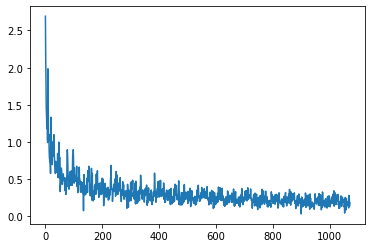

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Now that we have trained our RNN, it's time to evaluate it on the test set.

In [11]:
# Evaluation

import sklearn
from sklearn.metrics import precision_recall_fscore_support


def evaluate_result(true_tag_list, predicted_tag_list):
    # Example: true_tag_list/predicted_tag_list:
    #   [[‘O’, ‘O’, ‘I’, ‘N’, ...]
    #    [‘I’, ‘I’, ‘O’, ‘N’, ...]],
    # each sublist corresponds to an input sentence.
    p_list = []
    r_list = []
    f1_list = []
    for true_tag, predicted_tag in zip(true_tag_list, predicted_tag_list):
        p, r, f1, _ = precision_recall_fscore_support(true_tag, predicted_tag,
                                                      average='macro',
                                                      zero_division=0)
        p_list.append(p)
        r_list.append(r)
        f1_list.append(f1)
    return np.mean(p_list), np.mean(r_list), np.mean(f1_list)


# Making prediction
def rnn_predict_one_sent(model, sent_tensor):
    hidden = model.initHidden().to(device)
    ### Your code here! ###
    for i in range(sent_tensor.size()[0]):
        input = sent_tensor[i].view(1, -1)
        output, hidden = model(input, hidden)
        outputs = output if i == 0 else torch.cat((outputs, output), 0)
    predicted_tag_id = torch.argmax(outputs, axis=1)
    ###
    return predicted_tag_id


rnn_model.eval()
predicted_tags = []
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    predicted_tag_id = rnn_predict_one_sent(rnn_model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])

evaluate_result(test_tags, predicted_tags)
# TA note: with 5 epochs, (precision, recall, f1) = (0.73, 0.74, 0.73)
                                                  #new RNN gives  (0.755, 0.757, 0.749)

(0.7417461508050406, 0.7444671359648752, 0.7361034468819762)

## **Part 1: Lab writeup**

Part 1 of your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Compute the average gradient norm of all trainable parameters along the training. Plot a figure similar to what we did for training loss (x-axis is training iterations and y-axis is avg. gradient norm value). Describe what you find. Hint: gradient norm is the L2 norm of of the gradient vector.

# **Part 2: Long Short-Term Memory (LSTM)**

In part 2, you will implement your own LSTM. Same in part 1, you are not allowed to use PyTorch built-in LSTM/LSTMCell modules.

In [0]:
class LSTM(nn.Module):
    # A torch module implementing an LSTM. The `forward` function should just
    # perform one step of update and output logits before softmax.

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        ### Your code here! ###
        self.hidden_size = hidden_size

        self.i2fg = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2cg = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2ig = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2og = nn.Linear(input_size + hidden_size, hidden_size)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        self.i2o = nn.Linear(hidden_size, output_size)
        ###

    def forward(self, input, hidden, memory):
        # `input` is a 2d-tensor of shape (1, input_size);
        # `hidden` and `memory` are both 2d-tensors of shape (1, hidden_size),
        # representing the hidden and memory states of the previous time step.
        ### Your code here! ###
        combined = torch.cat((input, hidden), 1)

        f = self.sigmoid(self.i2fg(combined))
        i = self.sigmoid(self.i2ig(combined))
        o = self.sigmoid(self.i2og(combined))
        cg = self.tanh(self.i2cg(combined))

        memory = f * memory + i * cg

        hidden = o * self.tanh(memory)

        output = self.i2o(hidden)
        ###
        return output, hidden, memory

    def initHidden(self):
        # Initialize hidden and memory states.
        return (torch.zeros(1, self.hidden_size),
                torch.zeros(1, self.hidden_size))

Same with part 1, we provide the main training loop for training LSTM, but you will need to implement the `lstm_train_one_sample` function.

In [0]:
learning_rate = 1e-3
lstm_hidden_size = 128

lstm_model = LSTM(input_size=num_vocabs, hidden_size=lstm_hidden_size,
                  output_size=num_tags).to(device)

criterion = nn.CrossEntropyLoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(),  lr=learning_rate)


def lstm_train_one_sample(model, sent_tensor, tag_tensor):
    hidden, memory = model.initHidden()
    hidden = hidden.to(device)
    memory = memory.to(device)
    ### Your code here!
    for i in range(sent_tensor.size()[0]):
        input = sent_tensor[i].view(1, -1)
        output, hidden, memory = model(input, hidden, memory)
        outputs = output if i == 0 else torch.cat((outputs, output), 0)
    ###

    loss = criterion(outputs, tag_tensor)

    lstm_optimizer.zero_grad()
    loss.backward()
    lstm_optimizer.step()

    return outputs, loss.item()

LSTM main training loop:

In [21]:
n_epochs = 7
iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

lstm_model.train()
for epoch_i in range(n_epochs):
    for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
        sent_tensor = sent_tensor.to(device)
        tag_tensor = tag_tensor.to(device)
  
        output, loss = lstm_train_one_sample(lstm_model, sent_tensor, tag_tensor)
        current_loss += loss

        if iter_count % print_every == 0:
            print('%d %s %.4f' % (iter_count, timeSince(start), loss))

        # Add current loss avg to list of losses
        if iter_count % plot_every == 0 and iter_count > 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

        iter_count += 1

0 0m 0s 2.8322
1000 0m 11s 2.6397
2000 0m 21s 0.6436
3000 0m 32s 2.1736
4000 0m 44s 1.5316
5000 0m 54s 0.1179
6000 1m 5s 0.5942
7000 1m 15s 0.5148
8000 1m 25s 0.3833
9000 1m 36s 1.0172
10000 1m 46s 0.2781
11000 1m 58s 0.3767
12000 2m 9s 0.0249
13000 2m 19s 0.0585
14000 2m 30s 0.0217
15000 2m 40s 0.9056
16000 2m 50s 0.2255
17000 3m 1s 0.0081
18000 3m 11s 0.0595
19000 3m 23s 0.0198
20000 3m 34s 1.0479
21000 3m 44s 0.0438
22000 3m 54s 0.2546
23000 4m 4s 0.1644
24000 4m 15s 0.0050
25000 4m 26s 0.0326
26000 4m 37s 0.1966
27000 4m 48s 0.0120
28000 4m 59s 0.0073
29000 5m 9s 1.6859
30000 5m 19s 0.0507
31000 5m 29s 0.0065
32000 5m 41s 0.0032
33000 5m 50s 0.1139
34000 6m 2s 0.0362
35000 6m 13s 0.3925
36000 6m 24s 0.1330
37000 6m 34s 0.1607
38000 6m 44s 0.1588
39000 6m 54s 0.0101
40000 7m 5s 0.3084
41000 7m 16s 0.0039
42000 7m 27s 0.0504
43000 7m 38s 0.0092
44000 7m 48s 0.0012
45000 7m 59s 0.4891
46000 8m 9s 0.5683
47000 8m 20s 0.0389
48000 8m 30s 0.8315
49000 8m 41s 0.0463
50000 8m 52s 0.0109
51

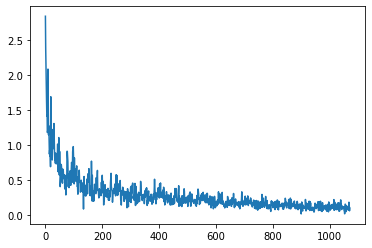

In [22]:
plt.figure()
plt.plot(all_losses)

Now let's evaluate our LSTM model.

In [23]:
def lstm_predict_one_sent(model, sent_tensor):
    hidden, memory = model.initHidden()
    hidden = hidden.to(device)
    memory = memory.to(device)
    ### Your code here! ###
    for i in range(sent_tensor.size()[0]):
        input = sent_tensor[i].view(1, -1)
        output, hidden, memory = model(input, hidden, memory)
        outputs = output if i == 0 else torch.cat((outputs, output), 0)
    predicted_tag_id = torch.argmax(outputs, axis=1)
    ###
    return predicted_tag_id


lstm_model.eval()
predicted_tags = []
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    predicted_tag_id = lstm_predict_one_sent(lstm_model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])

evaluate_result(test_tags, predicted_tags)
# TA note: with 5 epochs, (precision, recall, f1) = (0.78, 0.77, 0.76)
                                                  #new LSTM (0.7635, 0.7647, 0.7580)

(0.7591967469206881, 0.7617285705442315, 0.7539943627303572)

## **Part 2: Lab writeup**

Your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Change lstm_hidden_size so that LSTM has approximately the same amount of parameters as RNN. Hint: use sum(p.numel() for p in model.parameters() if p.requires_grad) to find #(trainable-params). Re-train the LSTM model and discuss your findings.

2. Same in part 1 writeup, plot the gradient norm figure for LSTM. Discuss your findings.

3. Currently we update model parameters for each sample (1 sample = 1 iteration). In practice, we usually train with a mini-batch (mB): the entire dataset is split into N/mB batches, and and use one mini-batch for each update. Describe how to do batching in our dataset. Hint: each sentence can have variable length.